# Imports

In [1]:
import pandas as pd
import yfinance as yf
import investpy as iv
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

from ta.volatility import BollingerBands
from ta.momentum import RSIIndicator
from ta.trend import MACD

import vectorbt as vbt
from vectorbt.portfolio import Orders

## Download Data

In [2]:
boi = pd.read_excel('/home/edilson07/projects/boi_gordo/data/boi_gordo.xlsx', index_col='Data').sort_index(ascending=True)

## Feature Engineering

In [3]:
boi.head()

,Abertura,Máxima,Mínima,Fechamento
Data,,,,
2003-01-02,62.13,62.13,62.08,62.13
2003-01-03,62.13,62.13,61.80,61.80
2003-01-06,61.69,61.97,61.53,61.97
2003-01-07,62.02,62.33,61.91,62.20
2003-01-08,62.24,62.24,61.69,61.69


## Returns

In [4]:
boi['Return'] = boi['Fechamento'].pct_change()

## Indicadores

In [6]:
# Médias Móveis
boi['MediaMovelCurto'] = boi['Fechamento'].rolling(window=13).mean()
boi['MediaMovelMedio'] = boi['Fechamento'].rolling(window=50).mean()
boi['MediaMovelLongo'] = boi['Fechamento'].rolling(window=200).mean()

# Bandas de Bollinger
bb = BollingerBands(close=boi['Fechamento'], window=20, window_dev=2)
boi['Bollinger_H'] = bb.bollinger_hband()
boi['Bollinger_L'] = bb.bollinger_lband()

# RSI
rsi_ind = RSIIndicator(close=boi['Fechamento'])
boi['RSI'] = rsi_ind.rsi()

# MACD
macd_int = MACD(close=boi['Fechamento'])
boi['MACD_Line'] = macd_int.macd()
boi['MACD_Diff'] = macd_int.macd_diff()
boi['MACD_Signal'] = macd_int.macd_signal()


boi.dropna(inplace=True)

## Sazonalidade

In [8]:
# Sazonalidade
boi['Mes'] = boi.index.month
boi['Estacao'] = boi.index.quarter

## Lag 1 one day

In [9]:
boi['Lagged_Close'] = boi['Fechamento'].shift(-2)

In [13]:
boi.head()

,Abertura,Máxima,Mínima,Fechamento,Return,MediaMovelCurto,MediaMovelMedio,MediaMovelLongo,Bollinger_H,Bollinger_L,RSI,MACD_Line,MACD_Diff,MACD_Signal,Mes,Estacao,Lagged_Close
Data,,,,,,,,,,,,,,,,,
2003-10-21,61.96,62.06,61.91,61.93,-0.000484,62.474615,63.8264,63.70065,63.850881,61.675119,26.029026,-0.516417,-0.041780,-0.474637,10,4,61.78
2003-10-22,61.91,61.91,61.61,61.62,-0.005006,62.346923,63.7796,63.69810,63.838294,61.515706,22.678640,-0.539577,-0.051952,-0.487625,10,4,61.81
2003-10-23,61.70,61.81,61.60,61.78,0.002597,62.230000,63.7322,63.69800,63.800751,61.409249,27.841245,-0.538809,-0.040948,-0.497862,10,4,61.81
2003-10-24,61.70,61.86,61.70,61.81,0.000486,62.134615,63.6856,63.69720,63.736408,61.328592,28.801150,-0.529675,-0.025451,-0.504224,10,4,61.74
2003-10-27,61.81,61.96,61.81,61.81,0.000000,62.063077,63.6402,63.69525,63.654538,61.265462,28.801150,-0.516482,-0.009806,-0.506676,10,4,61.82


In [11]:
boi = boi.fillna(0)

In [12]:
boi.columns

Index(['Abertura', 'Máxima', 'Mínima', 'Fechamento', 'Return',
       'MediaMovelCurto', 'MediaMovelMedio', 'MediaMovelLongo', 'Bollinger_H',
       'Bollinger_L', 'RSI', 'MACD_Line', 'MACD_Diff', 'MACD_Signal', 'Mes',
       'Estacao', 'Lagged_Close'],
      dtype='object')

## Pre-Processing

In [15]:
#pp_data = boi.drop(['Abertura','Máxima','Mínima'], axis=1)

In [16]:
#pp_data.columns

In [14]:
data = boi.copy()
cols_mms = ['Abertura', 'Máxima', 'Mínima', 'Return',
       'MediaMovelCurto', 'MediaMovelMedio', 'MediaMovelLongo', 'Bollinger_H',
       'Bollinger_L', 'RSI', 'MACD_Line', 'MACD_Diff', 'MACD_Signal']

mms = MinMaxScaler()

data[cols_mms] = mms.fit_transform(boi[cols_mms])

## Train-test Split

In [15]:
X = data.drop(['Lagged_Close','Fechamento', 'Abertura','Máxima','Mínima'], axis=1)
y = data[['Lagged_Close','Fechamento']]

mask_train = X.index < '2021-01-01'
mask_test = X.index >= '2021-01-01'


X_train = X[mask_train]
y_train = y.loc[mask_train,'Lagged_Close']

X_test = X[mask_test]
y_test = y.loc[mask_test, 'Fechamento']

## Linear Regression

In [16]:
lr = LinearRegression()

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

In [17]:
print(f'MAE: {mean_absolute_error(y_pred, y_test)}')
print(f'MAPE: {mean_absolute_percentage_error(y_pred, y_test)}')
print(f'RMSE: {mean_squared_error(y_pred, y_test, squared=False)}')
print(f'MSE: {mean_squared_error(y_pred, y_test)}')

MAE: 1.5655588240095502
MAPE: 0.005347660723912457
RMSE: 1.9764348033552501
MSE: 3.9062945319139066


In [18]:
y_pred = pd.DataFrame(y_pred, index=y_test.index, columns=['Fechamento_Predito'])

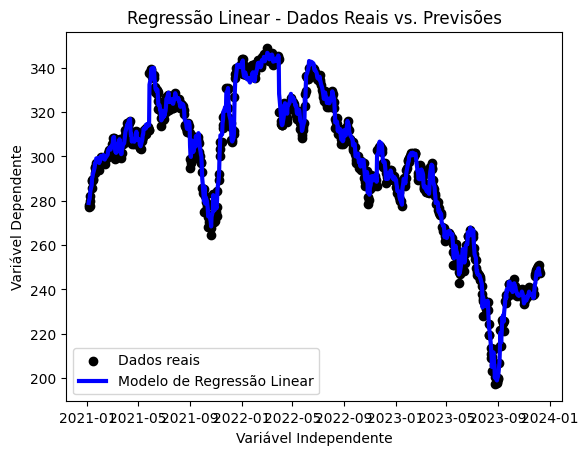

In [19]:
# Plote os resultados
plt.scatter(X_test.index, y_test, color='black', label='Dados reais')
plt.plot(X_test.index, y_pred, color='blue', linewidth=3, label='Modelo de Regressão Linear')
plt.title('Regressão Linear - Dados Reais vs. Previsões')
plt.xlabel('Variável Independente')
plt.ylabel('Variável Dependente')
plt.legend()
plt.show()

In [20]:
# Obtenha os coeficientes do modelo
coeficientes = lr.coef_
intercepto = lr.intercept_

# Imprima os coeficientes e o intercepto
print(f"Coeficientes: {coeficientes}")
print(f"Intercepto: {intercepto}")

# Imprima a equação da regressão linear
equacao_regressao = f"y = {intercepto:.2f} + {coeficientes[0]:.2f}x1 + {coeficientes[1]:.2f}x2 + ..."
print(f"Equação da Regressão Linear: {equacao_regressao}")

Coeficientes: [ 1.47024508e+01  2.47241327e+02 -1.89953947e+02 -1.41296634e+01
  1.39674731e+02  1.24937838e+02  9.11986414e-01 -1.26149274e+00
  6.02057579e+01 -2.60104626e+01 -4.65810801e-02  2.26878817e-01]
Intercepto: 20.869500204046574
Equação da Regressão Linear: y = 20.87 + 14.70x1 + 247.24x2 + ...


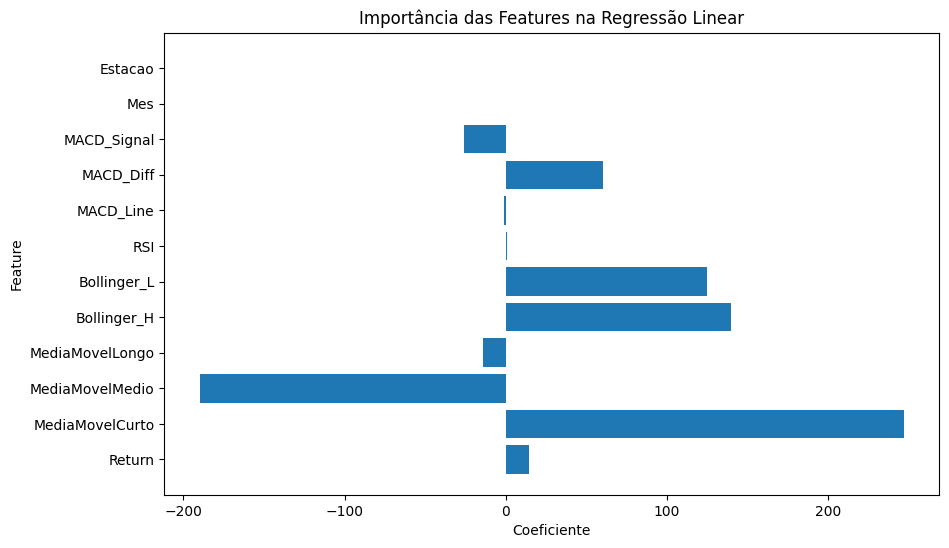

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Coeficientes do modelo de regressão linear
coeficientes = lr.coef_

# Nomes das features
nomes_features = X_train.columns

# Crie um gráfico de barras horizontais
plt.figure(figsize=(10, 6))
plt.barh(nomes_features, coeficientes)

# Adicione rótulos e título
plt.xlabel('Coeficiente')
plt.ylabel('Feature')
plt.title('Importância das Features na Regressão Linear')

# Exiba o gráfico
plt.show()


In [22]:
y_test

Data
2021-01-04    277.15
2021-01-05    277.95
2021-01-06    277.50
2021-01-07    279.85
2021-01-08    282.30
               ...  
2023-12-04    248.90
2023-12-05    250.70
2023-12-06    250.85
2023-12-07    248.55
2023-12-08    247.15
Name: Fechamento, Length: 732, dtype: float64

In [23]:
y_pred

,Fechamento_Predito
Data,
2021-01-04,279.000984
2021-01-05,280.322688
2021-01-06,280.716181
2021-01-07,282.643652
2021-01-08,284.485299
...,...
2023-12-04,247.811795
2023-12-05,249.425114
2023-12-06,249.463399


## Cross Validation

In [24]:
n_splits = 5

tscv = TimeSeriesSplit(n_splits=n_splits)

model = LinearRegression()

cv_results = cross_val_score(model, X[:-2], y['Lagged_Close'][:-2], cv=tscv, scoring='neg_mean_squared_error')

print("Resultados da validação cruzada:", cv_results)
print("Média dos resultados:", cv_results.mean())

Resultados da validação cruzada: [ -1.77617064  -1.7459579   -1.79608138  -9.0755093  -27.92369441]
Média dos resultados: -8.463482726900887


## Predict Everything

In [25]:
y_pred_full = lr.predict(X)

## Backtest

In [26]:
df_bt = boi.copy()

df_bt['Predicted'] = y_pred_full

# Converta o índice para o formato datetime se ainda não estiver
df_bt.index = pd.to_datetime(df_bt.index)

In [27]:
# Adicione uma coluna 'Signal' que representa os sinais de compra (+1), venda (-1), curta (-1) e cobertura (+1)

df_bt['Signal'] = 0  # inicializa todos os sinais como 0
df_bt.loc[df_bt['Signal'] == 0, 'Signal'] = np.where(df_bt['Predicted'] > df_bt['Fechamento'], 1, -1)
# Crie uma coluna 'Position' no DataFrame para armazenar as posições
df_bt['Position'] = 0
df_bt.dropna(inplace=True)        

In [28]:
# Implemente as regras do backtest
df_bt['Position'] = vbt.signals.first_choice(df_bt['Signals'], first_choice=1, choices=[-1, 0], wait=0)

# Execute o backtest
portfolio = vbt.Portfolio.from_signals(df_bt['Signals'], price=df_bt['Signals'], freq='d', cash_sharing=True)
portfolio = portfolio.apply_mask(df_bt['Position'].values)

# Resultados do backtest
print(portfolio.stats())

AttributeError: module 'vectorbt.signals' has no attribute 'first_choice'